## 1. Importing libraries

In [4]:
import torch
import gym
import numpy as np
import time
import cv2
import math
import random
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from collections import deque
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
import warnings
import os
from collections import OrderedDict
import torch
import torch.nn as nn
from torch.nn import Sequential, Conv2d, MaxPool2d, ReLU, Flatten, Linear, MSELoss
from torch.optim import Adam, SGD
from torchinfo import summary

In [2]:
warnings.filterwarnings("ignore")

## 2. Checking availability of GPU

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu") 
print("Device: ",device)

if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn)
    print('Device name:', torch.cuda.get_device_name(0))

Device:  cuda
__CUDNN VERSION: <module 'torch.backends.cudnn' from '/home/mario.cantero/.conda/envs/AIProject/lib/python3.8/site-packages/torch/backends/cudnn/__init__.py'>
Device name: Quadro RTX 6000


## 3. Creating the environment

In [5]:
env_si_or = gym.make("ALE/SpaceInvaders-v5")
env_si_or.seed(0);

env_c_or = gym.make("ALE/Carnival-v5")
env_c_or.seed(0);

env_ar_or = gym.make("ALE/AirRaid-v5")
env_ar_or.seed(0);

In [6]:
env_si = gym.make("SpaceInvaders-v0")
env_si.seed(0);

env_c = gym.make("Carnival-v0")
env_c.seed(0);

env_ar = gym.make("AirRaid-v0")
env_ar.seed(0);

## 4. Performance of a random policy

In [7]:
def random_play(env, number_of_episodes):
    for episodes in range(number_of_episodes):
        score = 0
        env.reset()
        lives = 3
        K = random.randint(10,20)
        number_of_frames = 0
        game_name = str(env.spec)
        if "SpaceInvaders" in game_name:
            env.render()
            for nopes in range(50):
                env.step(0) # Nope
        for frame in range(K):
            env.render()
            rand_init_state_action = random.randint(2,3)
            state, _, _, info = env.step(rand_init_state_action)
            number_of_frames += 1
            time.sleep(0)
        while True:
            env.render()
            action = env.action_space.sample()
            state, reward, done, info = env.step(action)
            if done:
                reward = -500
            number_of_frames += 1
            if info['lives'] != lives:
                lives -= 1
                print('You have lost a life', info)
            score += reward
            if done:
                env.close()
                print("Your Score at end of game is: ", score)
                break
            time.sleep(0)
        print(score)
        env.close()

## 5. Exploring the environments

In [8]:
for env in [env_si_or, env_c_or, env_ar_or]:
    print(f"The size of a {str(env.spec)} frame is: ", env.observation_space.shape)
    print("No. of Actions: ", env.action_space.n)

The size of a EnvSpec(ALE/SpaceInvaders-v5) frame is:  (210, 160, 3)
No. of Actions:  6
The size of a EnvSpec(ALE/Carnival-v5) frame is:  (214, 160, 3)
No. of Actions:  6
The size of a EnvSpec(ALE/AirRaid-v5) frame is:  (250, 160, 3)
No. of Actions:  6


In [9]:
for env in [env_si, env_c, env_ar]:
    print(f"The size of a {str(env.spec)} frame is: ", env.observation_space.shape)
    print("No. of Actions: ", env.action_space.n)

The size of a EnvSpec(SpaceInvaders-v0) frame is:  (210, 160, 3)
No. of Actions:  6
The size of a EnvSpec(Carnival-v0) frame is:  (214, 160, 3)
No. of Actions:  6
The size of a EnvSpec(AirRaid-v0) frame is:  (250, 160, 3)
No. of Actions:  6


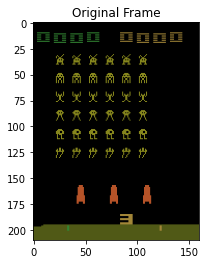

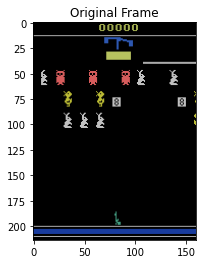

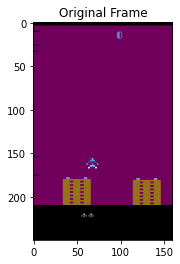

In [10]:
for env in [env_si, env_c, env_ar]:
    env.reset()
    plt.figure()
    plt.imshow(env.reset())
    plt.title('Original Frame')
    plt.show()

## 6. Image preprocessing and stacking frames

#### 6.1 Functions

In [11]:
def preprocess_state(state, game):
    # []
    game_name = str(game.spec)
    if game_name == "EnvSpec(SpaceInvaders-v0)":
        #initially, the image has a shape of (210, 160, 3)
        #crop and resize the image
        image = state[25:201:2, ::2]

    elif game_name == "EnvSpec(Carnival-v0)":
        #initially, the image has a shape of (214, 160, 3)
        #crop and resize the image
        image = state[36:207:2, :158:2]

    elif game_name == "EnvSpec(AirRaid-v0)":
        #initially, the image has a shape of (250, 160, 3)
        #crop and resize the image
        image = state[18:210:2, 8::2]

    #convert rgb image to grayscale
    #image = np.average(image,axis = 2)
    image = image.mean(axis = 2)
    scaler = MinMaxScaler()
    model = scaler.fit(image)
    image = model.transform(image)

    # Next we normalize the image from -1 to +1
    #image = (image - 128) / 128 - 1
    #image = image / 255
    #8-bit image

    #reshape the image
    image = cv2.resize(image,(84, 84),interpolation = cv2.INTER_NEAREST) # 76

    #print(image.shape, image.dtype)

    return image

out = preprocess_state(env_si.reset(), env_si)
#plt.figure()
#plt.imshow(out, cmap= "gray")
#plt.title('SpaceInvaders-v5')

In [12]:
stack_size = 4 # We stack 4 frames

# Initialize deque with zero-images one array for each image
stacked_frames_deque  =  deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)

def stack_frames(stacked_frames_deque, new_frame, is_new_episode, env):
    # Preprocess frame
    frame = preprocess_state(new_frame, env_si)
    
    if is_new_episode:
        # Clear our stacked_frames
        stacked_frames_deque = deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
        
        # Because we're in a new episode, copy the same frame 4x
        stacked_frames_deque.append(frame)
        stacked_frames_deque.append(frame)
        stacked_frames_deque.append(frame)
        stacked_frames_deque.append(frame)
        
        # Stack the frames
        stacked_frames = np.stack(stacked_frames_deque, axis=2)
        
    else:
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames_deque.append(frame)

        # Build the stacked state (first dimension specifies different frames)
        stacked_frames = np.stack(stacked_frames_deque, axis=2) 
    stacked_frames = torch.from_numpy(stacked_frames)
    stacked_frames = torch.reshape(stacked_frames, (1, stacked_frames.shape[2], stacked_frames.shape[0], stacked_frames.shape[1]))    
    
    return stacked_frames, stacked_frames_deque

#### 6.2 Image preview

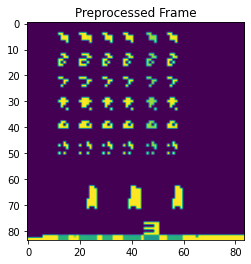

In [13]:
observation = env_si.reset()
observation = preprocess_state(observation, env_si)
plt.figure()
plt.imshow(observation)
plt.title('Preprocessed Frame')
plt.show()

## 7. Hyperparameters

In [14]:
def START_seed():
    seed = 0
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [15]:
input_shape = (84, 84, 4)
action_size = env_si.action_space.n
n_stacked_frames = 4
START_seed()
gamma = 0.99           # discount factor
buffer_size = 20000   # replay buffer size
pretrain_length = 1000 # Number of experiences used to filled an initialiazed memory
batch_size = 64        # Update batch size
learning_rate = 0.001            # learning rate 
tau = 1e-3             # for soft update of target parameters
update_every = 1       # how often to update the network
update_after = 10000  # After which thershold replay to be started

# Exploration vs Explotaition tradeoff, epsilon decays over time
eps_start = 0.99        # starting value of epsilon
eps_end = 0.01          # Ending value of epsilon
eps_decay = 3500         # Rate by which epsilon to be decayed

## 8. Neural networks

In [16]:
class DQN(nn.Module):

    def __init__(self, model_path='models/model.pt'):
        super().__init__()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model = None
        self.model_path = model_path

    def build_model(self, n_stacked_frames, n_actions, learning_rate):
        self.n_actions = n_actions
       # Architecture proposed in https://arxiv.org/abs/1312.5602

        self.model = Sequential(OrderedDict([
        ('conv_1', Conv2d(in_channels=n_stacked_frames, out_channels=16, kernel_size=(4, 4), stride=(4, 4))),
        ('activation_1', ReLU()),
        ('conv_2', Conv2d(in_channels=16, out_channels=32, kernel_size=(4, 4), stride=(2, 2))),
        ('activation_2', ReLU()),
        ('flatten', Flatten()),
        ('linear_1', Linear(in_features=2592, out_features=256)),
        ('activation_4', ReLU()),
        ('linear_2', Linear(in_features=256, out_features=n_actions))]))

        self.model.to(self.device)

        # create model file if not present
        if not os.path.isfile(self.model_path):
            self.save_model()

    def print_model(self):
        summary(model=self.model, input_size=(1, 4, 84, 84))

    def predict(self, state):
        state_tensor = torch.tensor(state)
        return self.model(state_tensor.float().to(device))

    def save_model(self):

        print('Saving model')
        torch.save({
            'state_dict': self.model.state_dict(),
        }, self.model_path)

## 9. The Replay Memory

In [17]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen = max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size), size = batch_size, replace = False)
        return [self.buffer[i] for i in index]

    def populating_memory(self, pretrain_length, env):
        for i in range(pretrain_length):
            # If it's the first step
            if i == 0:
                stacked_frames_deque  =  deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
                state = env.reset()
                state, stacked_frames_deque = stack_frames(stacked_frames_deque, state, True, env)
            # Get the next_state, the rewards, done by taking a random action
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)

            # Stack the frames
            next_state, stacked_frames_deque = stack_frames(stacked_frames_deque, next_state, False, env)
        
            # If the episode is finished (we're dead 3x)
            if done:
                # We finished the episode
                next_state = np.zeros(state.shape)
                
                # Add experience to memory
                self.add((state, action, reward, next_state, done))
                
                # Start a new episode
                state = env.reset()
                
                # Stack the frames
                state, stacked_frames_deque = stack_frames(stacked_frames_deque, state, True, env)
                
            else:
                # Add experience to memory
                self.add((state, action, reward, next_state, done))
                
                # Our new state is now the next_state
                state = next_state

## 9. Watching it play before training

## 10. Training the agent

#### 10.1 Decay of epsilon

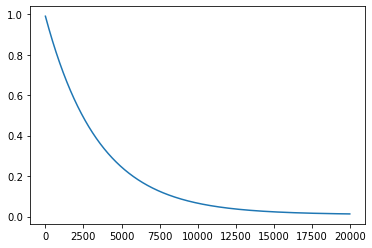

In [18]:
epsilon_by_episode = lambda frame_idx: eps_end + (eps_start - eps_end) * math.exp(-1. * frame_idx /eps_decay)
plt.plot([epsilon_by_episode(i) for i in range(20000)])

#### 10.2 Main training algorithm

![alt text](dql_algorithm.jpg "Title")

In [19]:
def train(n_episodes=1000, game=env_si):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    penalty = 0
    game_name = str(game.spec)
    loss_window = []
    scores = []
    scores_window = deque(maxlen=20)
    frames_deque = deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
    ########### Initialize replay memory D to capacity N (most of the sources indicate that N should be 1 million)
    memory = Memory(1000000)
    memory.populating_memory(1000, game)
    ########### Initialize action-value function Q with random weights Theta
    Q = DQN()
    Q.build_model(n_stacked_frames, action_size, learning_rate)
    ########### Initialize target action-value function Q_hat with weights Theta_ = Theta
    Q_hat = DQN()
    Q_hat.build_model(n_stacked_frames, action_size, learning_rate)
    Q_hat.load_state_dict(Q.state_dict())
    
    optimizer = SGD(lr=learning_rate, params=Q.parameters())
    #optimizer = Adam(lr=learning_rate, params=Q.parameters())
    loss = MSELoss()
    
    start_time = time.time()
    
    for i_episode in range(1, n_episodes+1):
        loss_list = []
        avg_loss = 0
        initial_frame = game.reset()
        stacked_frames, frames_deque = stack_frames(frames_deque, initial_frame, True, game)
        score = 0
        eps = epsilon_by_episode(i_episode)
        C = 0
        counter = 0
        rand_int_frames = random.randint(3,5)
        
        if "SpaceInvaders" in game_name:
            for nopes in range(50):
                new_frame, _, _, _ = game.step(0) # Nope
                stacked_frames, frames_deque = stack_frames(frames_deque, new_frame, False, game)
        
        K = random.randint(10,20)
        
        for _ in range(K):
            rand_init_state_action = random.randint(2,3)
            new_frame, _, _, _ = game.step(rand_init_state_action)
            stacked_frames, frames_deque = stack_frames(frames_deque, new_frame, False, game)
            
        while True:
            # Random frame skipping
            if counter % rand_int_frames == 0:
                if random.random() <= eps:
                    selected_a_t = game.action_space.sample()
                else:
                    q = Q.predict(stacked_frames)
                    selected_a_t = torch.argmax(q)
                rand_int_frames = random.randint(3,5)
            counter += 1

            action = selected_a_t ###### Action selected by the action-value function Q (neural network) with epsilon greedy policy

            next_frame, reward, done, _ = game.step(action)
            
            if done:
                penalty = -10
                reward += penalty
            
            next_stacked_frames, frames_deque = stack_frames(frames_deque, next_frame, False, game)
            
            ############### Here we store the transition (phi_(t), a_(t), r_(t), phi_(t+1)) in D
            memory.add((stacked_frames, action, reward, next_stacked_frames, done))
            
            ################# Training phase ######################
            ####### 1.- Sample random minibatch with uniform distribution of transitions (phi_(j), a_(j), r_(j), phi_(j+1)) from D
            minibatch = memory.sample(32)
            
            ####### 2.- Calculate the target value "y"
            
            target_q_values = torch.tensor([], requires_grad=True).to(device)
            predictions = torch.tensor([], requires_grad=True).to(device)

            for s_t, a_t, r_t, s_t1, done in minibatch:
                q_hat_s_t1 = Q_hat.predict(s_t1)  # Predicted Q values for the next state
                target = Q.predict(s_t)  # Predicted Q values

                new_target = torch.tensor([r_t + (1 - done) * gamma * torch.max(q_hat_s_t1)]).to(device)
                predicted_q_value = torch.tensor(target[0, a_t]).to(device)
                predicted_q_value = predicted_q_value.unsqueeze(0)
                
                target_q_values = torch.cat((target_q_values, new_target), dim=0)
                predictions = torch.cat((predictions, predicted_q_value), dim=0)
            
            loss_computation = loss(predictions, target_q_values)
            optimizer.zero_grad()
            loss_computation.backward()
            optimizer.step()
            loss_test = loss_computation.item()
            
            loss_list.append(loss_computation.tolist())
            avg_loss = np.mean(loss_list)

            stacked_frames = next_stacked_frames
            score += reward
            
            ############### Every C steps reset Q_hat = Q, we train only on Q
            if C % 10 == 0:
                Q_hat.load_state_dict(Q.state_dict())
            if done:
                break
        
        loss_window.append(avg_loss)
        score = score + penalty
        scores_window.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        # Plotting
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            fig = plt.figure()
            ax = fig.add_subplot(111)
            plt.plot(np.arange(len(scores)), scores)
            plt.ylabel('Score')
            plt.xlabel('Episode #')
            plt.show()
            
            print('\rEpisode {}\tAverage Loss: {:.2f}'.format(i_episode, avg_loss))
            fig = plt.figure()
            ax = fig.add_subplot(111)
            plt.plot(np.arange(len(loss_window)), loss_window)
            plt.ylabel('Loss')
            plt.xlabel('Episode #')
            plt.show()
    print("--- %s seconds ---" % round(time.time() - start_time, 2))
    return Q, memory, memory_info, scores, loss_window

Episode 100	Average Score: 14.25


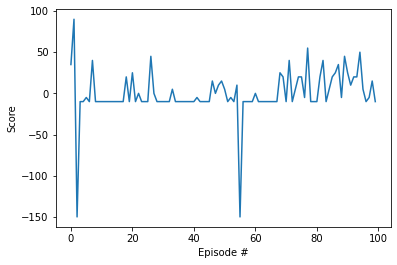

Episode 100	Average Loss: 2.53


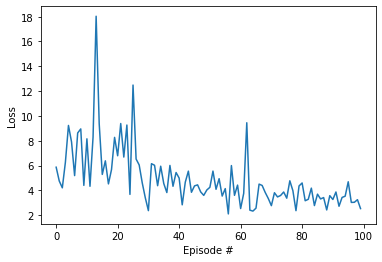

Episode 200	Average Score: 0.0050


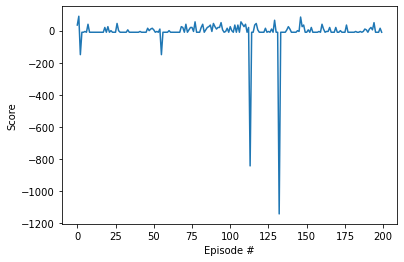

Episode 200	Average Loss: 1.35


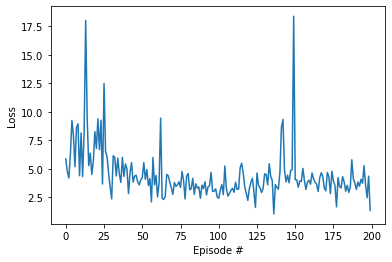

Episode 300	Average Score: 1.500


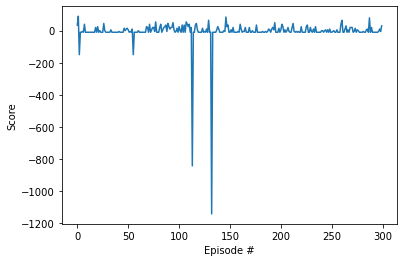

Episode 300	Average Loss: 2.97


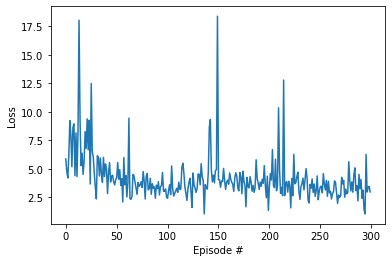

Episode 400	Average Score: -1.2550


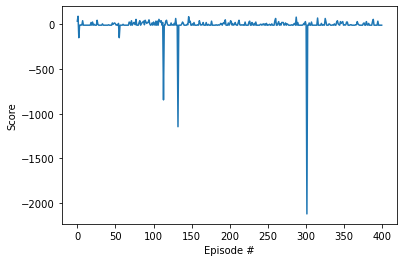

Episode 400	Average Loss: 3.73


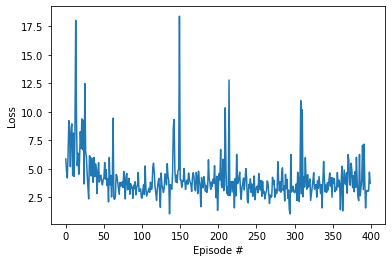

Episode 500	Average Score: 17.75


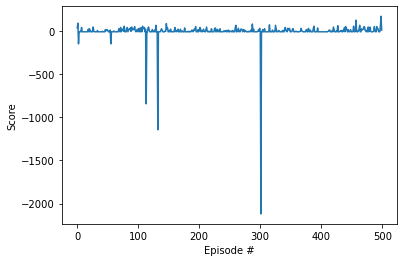

Episode 500	Average Loss: 3.97


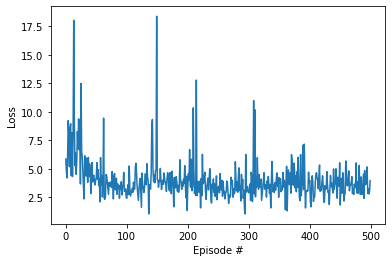

Episode 600	Average Score: 5.7550


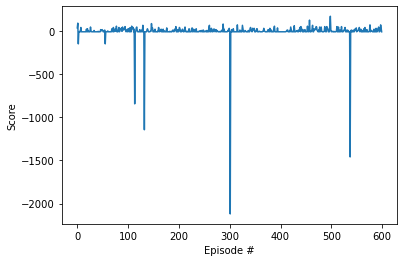

Episode 600	Average Loss: 3.79


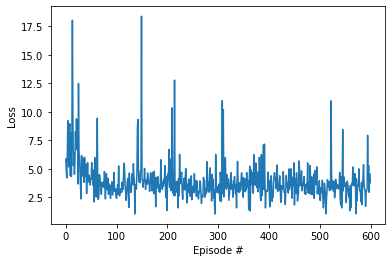

Episode 700	Average Score: -26.75


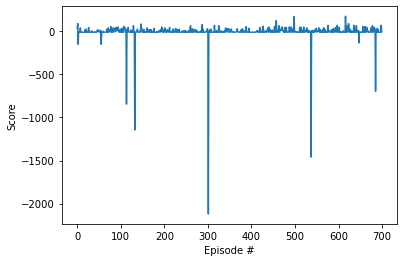

Episode 700	Average Loss: 4.44


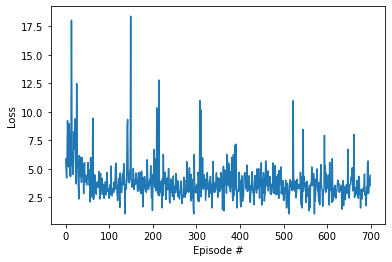

Episode 800	Average Score: 6.7505


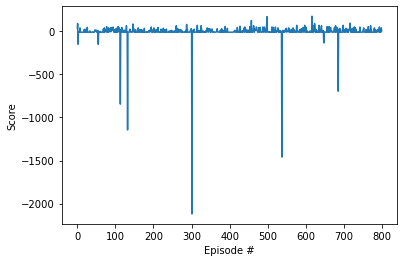

Episode 800	Average Loss: 3.42


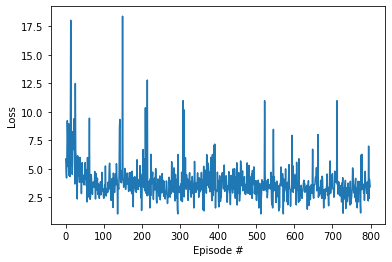

Episode 900	Average Score: 16.00


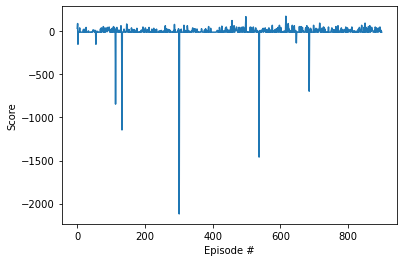

Episode 900	Average Loss: 2.97


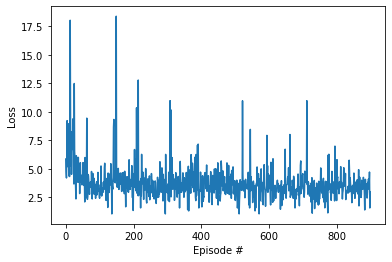

Episode 1000	Average Score: 10.50


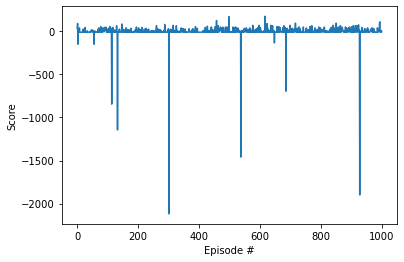

Episode 1000	Average Loss: 3.83


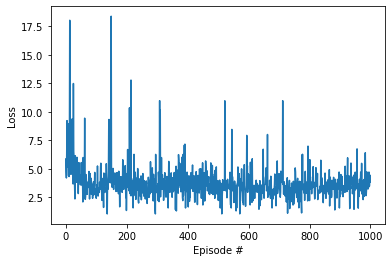

Episode 1100	Average Score: 15.25


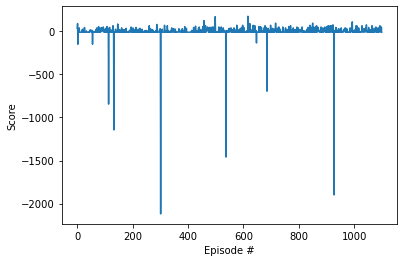

Episode 1100	Average Loss: 2.29


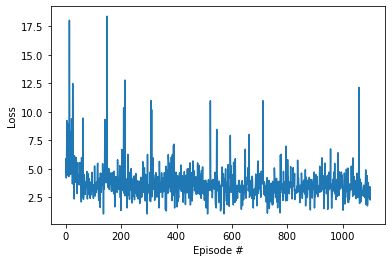

Episode 1200	Average Score: -4.7525


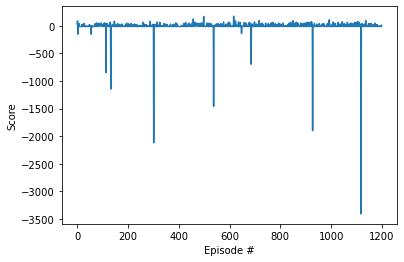

Episode 1200	Average Loss: 4.07


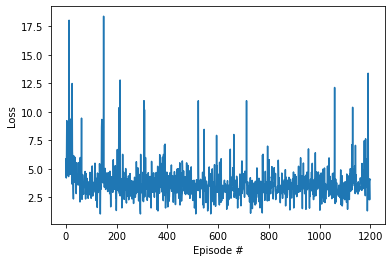

Episode 1300	Average Score: 10.25


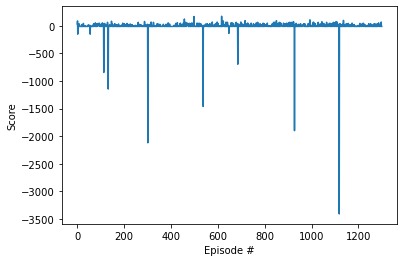

Episode 1300	Average Loss: 3.01


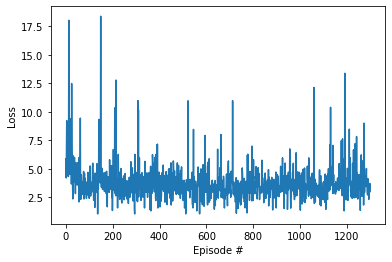

Episode 1400	Average Score: 2.5050


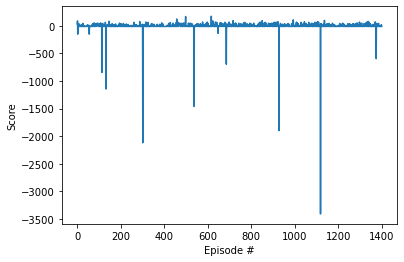

Episode 1400	Average Loss: 2.16


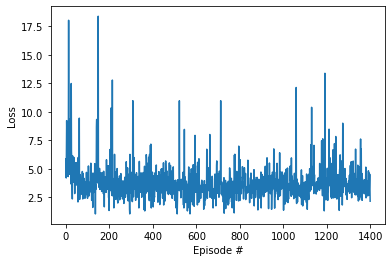

Episode 1500	Average Score: 8.750


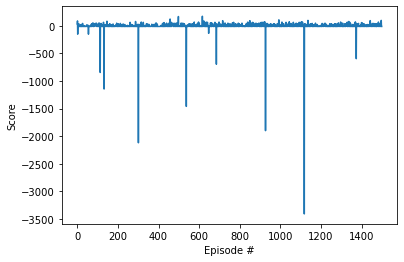

Episode 1500	Average Loss: 3.08


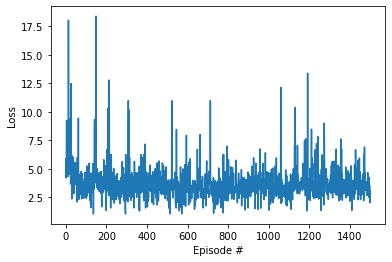

Episode 1600	Average Score: 2.00025


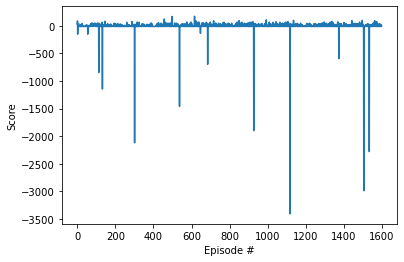

Episode 1600	Average Loss: 3.64


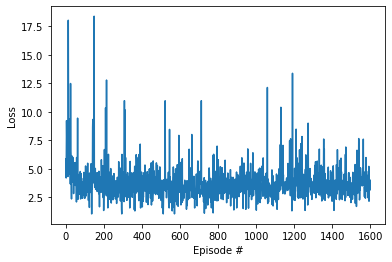

Episode 1700	Average Score: 7.755


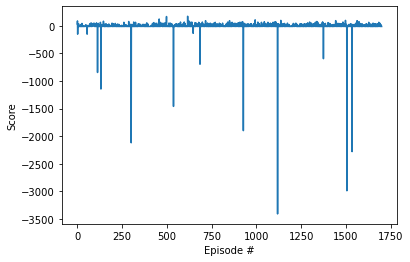

Episode 1700	Average Loss: 1.58


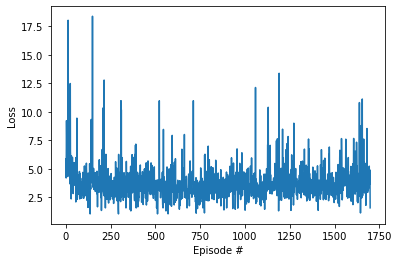

Episode 1800	Average Score: -2.75


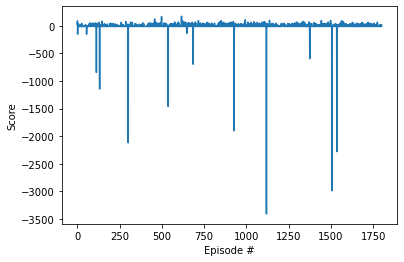

Episode 1800	Average Loss: 3.00


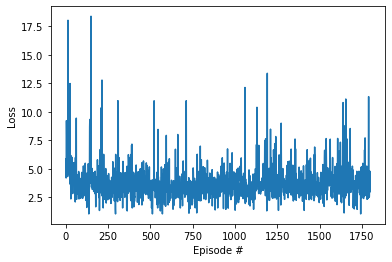

Episode 1814	Average Score: 6.255

In [ ]:
agent, memory, memory_info, scores, loss_window = train(20000, env_si)

In [52]:
memory_info

{'Episode at which the memory got full': 641,
 'Overflowed transitions': 1051938,
 'Flag': False}

## 11. Evaluate the agent

In [171]:
env_si.close()

In [257]:
def evaluate(game, agent, number_of_episodes):
    scores_per_episode = []
    for i_episodes in range(number_of_episodes):
        score = 0
        initial_frame = game.reset()
        stacked_frames_deque  =  deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
        stacked_frames, stacked_frames_deque = stack_frames(stacked_frames_deque, initial_frame, True, game) ############ Here we need the preprocessing function
        counter = 0
        rand_int_frames = random.randint(3,5)
        while True:
            game.render()
            if counter % rand_int_frames == 0:
                q = agent.predict(stacked_frames)
                a_t = torch.argmax(q) ###### Action selected by the action-value function Q (neural network) with epsilon greedy policy
                rand_int_frames = random.randint(3,5)
            counter += 1
            next_frame, reward, done, _ = game.step(a_t)
            score += reward
            stacked_frames, stacked_frames_deque = stack_frames(stacked_frames_deque, next_frame, False, game) ########## Here we need the preprocessing function
            if done:
                break
            time.sleep(0.1)
        game.close()
        scores_per_episode.append(score)
    return scores_per_episode

In [259]:
env_si.close()

In [258]:
scores_neg_reward = evaluate(env_si, agent, 5)

KeyboardInterrupt: 

In [251]:
sum(scores)/len(scores)

211.6

In [240]:
scores = evaluate(env_si, agent2, 100)

You Final score is: 150.0
You Final score is: 180.0
You Final score is: 90.0
You Final score is: 375.0
You Final score is: 305.0
You Final score is: 135.0
You Final score is: 325.0
You Final score is: 355.0
You Final score is: 275.0
You Final score is: 100.0
You Final score is: 135.0
You Final score is: 130.0
You Final score is: 105.0
You Final score is: 470.0
You Final score is: 485.0
You Final score is: 210.0
You Final score is: 110.0
You Final score is: 30.0
You Final score is: 110.0
You Final score is: 350.0
You Final score is: 60.0
You Final score is: 55.0
You Final score is: 90.0
You Final score is: 465.0
You Final score is: 320.0
You Final score is: 290.0
You Final score is: 65.0
You Final score is: 80.0
You Final score is: 15.0
You Final score is: 100.0
You Final score is: 145.0
You Final score is: 15.0
You Final score is: 425.0
You Final score is: 15.0
You Final score is: 170.0
You Final score is: 85.0
You Final score is: 80.0
You Final score is: 90.0
You Final score is: 115.0

In [ ]:
agent.state_dict()

In [ ]:
print('Saving model')
torch.save({'state_dict': agent.model.state_dict()}, '/home/mario.cantero/AI701Project_MNM_RL/agent_neg_reward.pt')

In [210]:
agent2 = DQN()

In [211]:
agent2.build_model(n_stacked_frames, action_size, learning_rate)
agent2.model.load_state_dict(torch.load('/home/mario.cantero/AI701Project_MNM_RL/agent.pt')['state_dict'])

<All keys matched successfully>

In [204]:
scores[-100:]

[5.0,
 5.0,
 0.0,
 40.0,
 35.0,
 0.0,
 95.0,
 0.0,
 95.0,
 60.0,
 60.0,
 0.0,
 40.0,
 45.0,
 30.0,
 15.0,
 55.0,
 0.0,
 70.0,
 -124420.0,
 0.0,
 15.0,
 30.0,
 5.0,
 110.0,
 25.0,
 50.0,
 65.0,
 0.0,
 0.0,
 0.0,
 95.0,
 40.0,
 0.0,
 20.0,
 0.0,
 85.0,
 0.0,
 0.0,
 0.0,
 0.0,
 150.0,
 135.0,
 0.0,
 100.0,
 -1475.0,
 0.0,
 45.0,
 0.0,
 75.0,
 45.0,
 125.0,
 0.0,
 65.0,
 55.0,
 60.0,
 -13355.0,
 30.0,
 45.0,
 5.0,
 45.0,
 70.0,
 35.0,
 5.0,
 55.0,
 0.0,
 95.0,
 80.0,
 35.0,
 0.0,
 0.0,
 130.0,
 40.0,
 10.0,
 0.0,
 0.0,
 0.0,
 10.0,
 5.0,
 0.0,
 0.0,
 50.0,
 10.0,
 0.0,
 10.0,
 0.0,
 0.0,
 70.0,
 0.0,
 55.0,
 25.0,
 0.0,
 0.0,
 70.0,
 0.0,
 0.0,
 10.0,
 0.0,
 55.0,
 120.0]